## Import libraries

In [174]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
import torch.optim as optim

# import torchvision.transforms as transforms


## Load images and labels

In [387]:
# Function to load images from a folder and convert them to a tensor
def load_images_and_labels(images_path, labels_path):
    df_labels = pd.read_csv(labels_path)
    images_paths = os.listdir(images_path)
    images = []
    labels = []
    for filename in tqdm(images_paths, desc = "Reading images"):
        if filename.endswith(".png"):
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img) / 255
            label = df_labels[df_labels['Image'] == filename]['Class'].values[0]
            images.append(img_array)
            labels.append(label)
    labels = np.array(labels)
    images = np.array(images)
    labels_tensor = torch.Tensor(labels)
    images_tensor = torch.Tensor(images)
    return images_tensor, labels_tensor


In [332]:
# Specify the paths
train_images_folder_path = "train_images"
labels_path = "train.csv"

# Load images and labels into tensors
train_images, train_labels = load_images_and_labels(train_images_folder_path, labels_path)

# Print the shapes of the resulting tensors
print("Images Tensor Shape:", train_images.shape)
print("Labels Tensor Shape:", train_labels.shape)


Reading images: 100%|██████████| 13000/13000 [02:00<00:00, 107.46it/s]


Images Tensor Shape: torch.Size([13000, 64, 64, 3])
Labels Tensor Shape: torch.Size([13000])


In [543]:
# Specify the paths
test_images_folder_path = "test_images"
labels_path = "predictions2.csv"

# Load images and labels into tensors
test_images, test_labels = load_images_and_labels(test_images_folder_path, labels_path)

# Print the shapes of the resulting tensors
print("Images Tensor Shape:", test_images.shape)
print("Labels Tensor Shape:", test_labels.shape)


Reading images: 100%|██████████| 5000/5000 [00:08<00:00, 607.09it/s]


Images Tensor Shape: torch.Size([5000, 64, 64, 3])
Labels Tensor Shape: torch.Size([5000])


## EDA

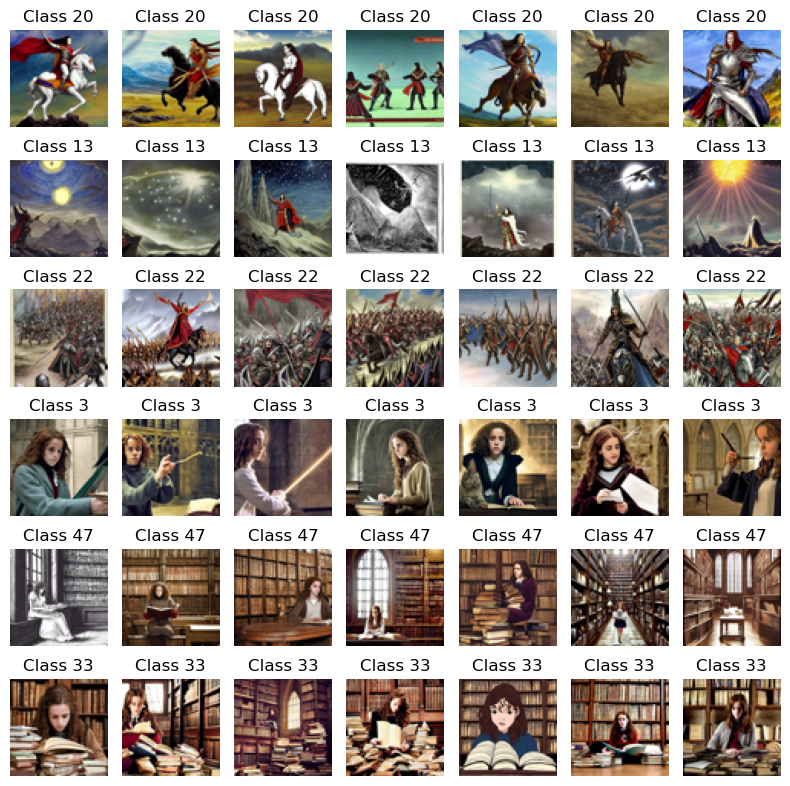

In [544]:
num_examples_to_display = 7
# Create subplots
fig, axes = plt.subplots(6, 7, figsize=(8, 8))

# Flatten the axes to simplify indexing
axes = axes.flatten()
i = 0

for label in [20, 13, 22, 3, 47, 33]:
    indices_in_class = np.where(test_labels == label)[0][:num_examples_to_display]
    for index in indices_in_class:
        example_image = test_images[index, :, :, :].numpy() 
        # print(f"   Example {index}: {example_image.shape}")
        # print(f"   Min value: {example_image.min()}")
        # print(f"   Max value: {example_image.max()}")
        axes[i].imshow(example_image)
        axes[i].axis('off')  # Turn off axis labels
        axes[i].title.set_text(f"Class {label}")
        i += 1
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
for label in [0, 1, 2, 3, 4, 5]:
    indices_in_class = np.where(train_labels == label)[0][:num_examples_to_display]
    print(f"Class {label}: {indices_in_class}")


Class 0: [  0  82 317 419 458 704 708]
Class 1: [ 26 109 251 476 500 523 595]
Class 2: [125 221 299 465 522 599 620]
Class 3: [ 77 166 532 539 545 759 782]
Class 4: [ 10 203 320 488 738 765 784]
Class 5: [160 310 388 430 461 473 568]


## Dataset

In [52]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_images_permuted = train_images.permute((0, 3, 2, 1))
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_images_permuted, train_labels, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to('cuda')
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to('cuda')
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to('cuda')
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to('cuda')



/tmp/ipykernel_22081/1680813317.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to('cuda')
/tmp/ipykernel_22081/1680813317.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to('cuda')
/tmp/ipykernel_22081/1680813317.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to('cuda')
/tmp/ipykernel_22081/1680813317.py:16: UserWarning: To copy construct from a ten

In [53]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([10400, 3, 64, 64]),
 torch.Size([10400]),
 torch.Size([2600, 3, 64, 64]),
 torch.Size([2600]))

## Train functions

In [485]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size = 32, num_epochs = 10, save_weights = False, weights_path="weights", last_epoch = 0):
    val_loss_array = []
    val_acc_array = []
    train_loss_array = []
    train_acc_array = []
    
    # Create a DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = model.to('cuda')
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
    
        for inputs, labels in train_loader:
            inputs = inputs.to('cuda') # Move input data to GPU
            labels = labels.type(torch.LongTensor)
            labels = labels.to('cuda')

            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(inputs)
            # outputs = outputs.view(outputs.size(0), -1) 
            loss = criterion(outputs, labels)
    
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
            # Calculate train accuracy
            
            # _, predicted = torch.max(outputs, 1)
            # correct_predictions += (predicted == labels.flatten().type(torch.cuda.FloatTensor)).sum().item()
            # predictions = (outputs > 0.5).float()
            predictions = torch.argmax(outputs, dim=1).float()
            correct_predictions += (predictions == labels).sum().item()
            
            total_samples += labels.size(0)
    
        average_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples
        print(f'Epoch [{last_epoch + epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%')
        val_loss, val_accuracy = validate(model, X_val, y_val, batch_size, nn.CrossEntropyLoss())
        print(f'Epoch [{last_epoch + epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')
        if save_weights:
            if val_accuracy > 0.7:
                torch.save(model.state_dict(), f'weights/{weights_path}_epoch{last_epoch + epoch + 1}.pth')
                print("weights saved")
                max_accuracy = val_accuracy

        val_loss_array.append(val_loss)
        val_acc_array.append(val_accuracy)
        train_loss_array.append(average_loss)
        train_acc_array.append(accuracy)
    return val_loss_array, val_acc_array, train_loss_array, train_acc_array

In [12]:
def validate(model, X, y, batch_size, criterion = nn.CrossEntropyLoss()):
   
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for inputs, labels in data_loader:
            inputs = inputs.to('cuda') # Move input data to GPU
            labels = labels.type(torch.LongTensor)
            labels = labels.to('cuda')

            # Assuming inputs and labels are already on the GPU if using CUDA
            outputs = model(inputs)
            # outputs = outputs.view(outputs.size(0), -1) 
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Convert outputs to binary predictions (0 or 1) based on a threshold (e.g., 0.5 for sigmoid)
            # predictions = (outputs > 0.5).float()
            predictions = torch.argmax(outputs, dim=1).float()
            correct_predictions += (predictions == labels).sum().item()

            total_samples += labels.size(0)

    # Calculate average loss and accuracy
    average_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    return average_loss, accuracy


## CNN models

### Resnet 1 -> PREDICTION2

In [492]:
# Define the basic block for ResNet
class BasicBlock(nn.Module):
    extansion = 1

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_channels != self.extansion * out_channels:
        #     print("reached downsample", in_channels, self.extansion * out_channels)
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_channels, self.extansion * out_channels, kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(self.extansion * out_channels)
            # )
        self.downsample = None
        # if is_first_block and stride != 1:
        if stride != 1 or in_channels != self.extansion * out_channels:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                                      out_channels= out_channels,
                                                      kernel_size=1,
                                                      stride=stride,
                                                      padding=0),
                                            nn.BatchNorm2d(out_channels))

    def forward(self, x):
        residual = x.clone()
        # print("block initial shape:", x.shape)
        x = self.relu(self.bn1(self.conv1(x)))
        # print("block shape after conv1:", x.shape)
        x = self.bn2(self.conv2(x))
        # print("block shape after conv2:", x.shape)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        # print("block shape after residual:", x.shape)
        x = self.relu(x)
        return x


In [290]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], 3, 1, 1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1]*block.extansion, 3, 2, 1)
        self.layer3 = self.make_layer(block, 256, num_blocks[2]*block.extansion, 3, 2, 1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.extansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, kernel_size, stride, padding):
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding))
        self.in_channels = out_channels * block.extansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, kernel_size, 1, padding))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # print("resnet first layers shape:", x.shape)
        x = self.layer1(x)
        # print("layer1 shape:", x.shape)
        x = self.layer2(x)
        # print("layer2 shape:", x.shape)
        x = self.layer3(x)
        # print("layer3 shape:", x.shape)
        # Classification head
        y = self.avg_pool(x)
        y = y.reshape(y.shape[0], -1)
        # print("classification shape:", y.shape)
        y = self.fc(y)
        # print("classification shape:", y.shape)
        return y



In [489]:
model = ResNet(BasicBlock, [2, 2, 2, 2])
# model = model.to("cuda")
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [262]:
model = ResNet(BasicBlock, [2, 2, 2, 2])
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 30, save_weights = False, weights_path = "resnet18")

Epoch [1/30], Train Loss: 3.5435, Train Accuracy: 12.69%
Epoch [1/30], Val Loss: 3.0771, Val Accuracy: 19.15%
Epoch [2/30], Train Loss: 2.6078, Train Accuracy: 28.99%
Epoch [2/30], Val Loss: 3.1417, Val Accuracy: 24.88%
Epoch [3/30], Train Loss: 2.1788, Train Accuracy: 38.25%
Epoch [3/30], Val Loss: 2.3407, Val Accuracy: 37.15%
Epoch [4/30], Train Loss: 1.9069, Train Accuracy: 45.03%
Epoch [4/30], Val Loss: 2.6857, Val Accuracy: 34.12%
Epoch [5/30], Train Loss: 1.6849, Train Accuracy: 50.97%
Epoch [5/30], Val Loss: 2.1377, Val Accuracy: 41.85%
Epoch [6/30], Train Loss: 1.5179, Train Accuracy: 55.36%
Epoch [6/30], Val Loss: 1.8053, Val Accuracy: 47.54%
Epoch [7/30], Train Loss: 1.3885, Train Accuracy: 58.59%
Epoch [7/30], Val Loss: 1.8483, Val Accuracy: 46.88%
Epoch [8/30], Train Loss: 1.2757, Train Accuracy: 61.74%
Epoch [8/30], Val Loss: 1.7936, Val Accuracy: 48.96%
Epoch [9/30], Train Loss: 1.1608, Train Accuracy: 64.79%
Epoch [9/30], Val Loss: 1.5244, Val Accuracy: 57.00%
Epoch [10/

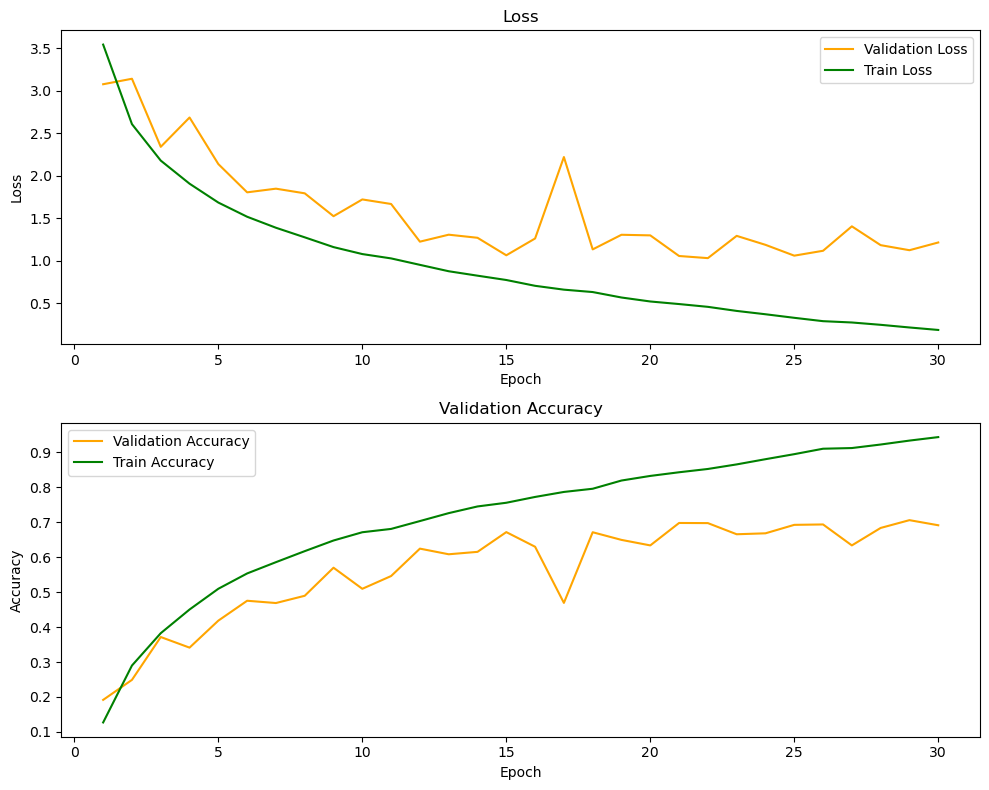

In [263]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
epochs = range(1, len(val_loss_array)+1)
# Plot validation loss
ax1.plot(epochs, val_loss_array, 'orange', label='Validation Loss')
ax1.plot(epochs, train_loss_array, 'green',  label='Train Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(epochs, val_acc_array, 'orange', label='Validation Accuracy')
ax2.plot(epochs, train_acc_array, 'green', label='Train Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [264]:
torch.save(model.state_dict(), f'weights/resnet_var1_epoch30.pth')

### Resnet 2

In [567]:
# Define the basic block for ResNet
class BasicBlock_bottleneck(nn.Module):
    extansion = 3

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BasicBlock_bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.extansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.extansion)

        # Shortcut connection to match dimensions
        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_channels != self.extansion * out_channels:
        #     print("reached downsample", in_channels, self.extansion * out_channels)
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_channels, self.extansion * out_channels, kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(self.extansion * out_channels)
            # )
        self.downsample = None
        # if is_first_block and stride != 1:
        if stride != 1 or in_channels != self.extansion * out_channels:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                                      out_channels= out_channels * self.extansion,
                                                      kernel_size=1,
                                                      stride=stride,
                                                      padding=0),
                                            nn.BatchNorm2d(out_channels * self.extansion))

    def forward(self, x):
        residual = x.clone()
        # print("block initial shape:", x.shape)
        x = self.relu(self.bn1(self.conv1(x)))
        # print("block shape after conv1:", x.shape)
        x = self.relu(self.bn2(self.conv2(x)))
        # print("block shape after conv2:", x.shape)
        x = self.bn3(self.conv3(x))
        # print("block shape after conv3:", x.shape)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        # print("block shape after residual:", x.shape)
        x = self.relu(x)
        return x


In [566]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], 3, 1, 1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1]*block.extansion, 3, 2, 1)
        self.layer3 = self.make_layer(block, 256, num_blocks[2]*block.extansion, 3, 2, 1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.extansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, kernel_size, stride, padding):
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding))
        self.in_channels = out_channels * block.extansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, kernel_size, 1, padding))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # print("resnet first layers shape:", x.shape)
        x = self.layer1(x)
        # print("layer1 shape:", x.shape)
        x = self.layer2(x)
        # print("layer2 shape:", x.shape)
        x = self.layer3(x)
        # print("layer3 shape:", x.shape)
        # Classification head
        y = self.avg_pool(x)
        y = y.reshape(y.shape[0], -1)
        # print("classification shape:", y.shape)
        y = self.fc(y)
        # print("classification shape:", y.shape)
        return y



In [568]:
model = ResNet(BasicBlock_bottleneck, [2, 2, 2, 2])
# model = model.to("cuda")
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [569]:
model = ResNet(BasicBlock_bottleneck, [2, 2, 2, 2])
model = model.to("cuda")
max_accuracy = 70
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 30, save_weights = True, weights_path = "resnet_3")

Epoch [1/30], Train Loss: 3.6654, Train Accuracy: 11.03%
Epoch [1/30], Val Loss: 3.5354, Val Accuracy: 15.69%
Epoch [2/30], Train Loss: 2.7287, Train Accuracy: 26.50%
Epoch [2/30], Val Loss: 2.7911, Val Accuracy: 25.42%
Epoch [3/30], Train Loss: 2.2888, Train Accuracy: 35.98%
Epoch [3/30], Val Loss: 2.2216, Val Accuracy: 39.00%
Epoch [4/30], Train Loss: 1.9896, Train Accuracy: 43.00%
Epoch [4/30], Val Loss: 2.1346, Val Accuracy: 40.04%
Epoch [5/30], Train Loss: 1.7846, Train Accuracy: 47.55%
Epoch [5/30], Val Loss: 2.4831, Val Accuracy: 41.38%
Epoch [6/30], Train Loss: 1.6004, Train Accuracy: 52.59%
Epoch [6/30], Val Loss: 2.1378, Val Accuracy: 40.58%
Epoch [7/30], Train Loss: 1.4794, Train Accuracy: 56.02%
Epoch [7/30], Val Loss: 1.4357, Val Accuracy: 57.46%
Epoch [8/30], Train Loss: 1.3331, Train Accuracy: 60.01%
Epoch [8/30], Val Loss: 1.4401, Val Accuracy: 58.04%
Epoch [9/30], Train Loss: 1.2252, Train Accuracy: 63.11%
Epoch [9/30], Val Loss: 1.3786, Val Accuracy: 59.62%
Epoch [10/

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
epochs = range(1, len(val_loss_array)+1)
# Plot validation loss
ax1.plot(epochs, val_loss_array, 'orange', label='Validation Loss')
ax1.plot(epochs, train_loss_array, 'green',  label='Train Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(epochs, val_acc_array, 'orange', label='Validation Accuracy')
ax2.plot(epochs, train_acc_array, 'green', label='Train Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### CNN model 1

In [111]:
class CNN_model1(nn.Module):
    def __init__(self):
        super(CNN_model1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(3200, 100)
            
            # nn.Linear(1024, 100)
        )
        # Add a custom convolutional layer
        # self.relu = nn.ReLU()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=11)
        # self.maxpool1 = nn.MaxPool2d(kernel_size = 3)
        # self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        
        # # # Remove the fully connected layers at the end
       
        # self.dropout = nn.Dropout(0.5)
        # self.flatten = nn.Flatten()
        # # # Fully connected layer for predictions
        # self.fc = nn.Linear(25088, 100)

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.relu(x)
        # # # print(x.shape)
        # x = self.maxpool1(x)
        # # # print(x.shape)
        # x = self.conv2(x)
        # x = self.relu(x)
        # # # print(x.shape)
        # # x = self.maxpool1(x)
        # x = self.dropout(x)
        # # # print(x.shape)
        # x = self.flatten(x)
        # x = self.fc(x)
        # x = F.softmax(x, dim=1)
        x = self.features(x) 
        # print(x.shape)
        x = self.classifier(x)
        return x

# Create an instance of the modified ResNet50 model
model = CNN_model1()

# Display the model summary
print(model)


CNN_model1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  

In [112]:
model = CNN_model1()
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [113]:
# model = CNN_model1()
# model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 100, save_weights = False, weights_path = "resnet18")

Epoch [1/100], Train Loss: 4.2890, Train Accuracy: 9.86%
Epoch [1/100], Val Loss: 3.7639, Val Accuracy: 15.77%
Epoch [2/100], Train Loss: 3.4150, Train Accuracy: 20.33%
Epoch [2/100], Val Loss: 5.3961, Val Accuracy: 12.42%
Epoch [3/100], Train Loss: 2.8516, Train Accuracy: 28.72%
Epoch [3/100], Val Loss: 2.7604, Val Accuracy: 30.04%
Epoch [4/100], Train Loss: 2.4695, Train Accuracy: 34.31%
Epoch [4/100], Val Loss: 3.3250, Val Accuracy: 21.81%
Epoch [5/100], Train Loss: 2.1738, Train Accuracy: 40.26%
Epoch [5/100], Val Loss: 2.2873, Val Accuracy: 38.42%
Epoch [6/100], Train Loss: 1.9858, Train Accuracy: 44.34%
Epoch [6/100], Val Loss: 2.0179, Val Accuracy: 43.73%
Epoch [7/100], Train Loss: 1.8166, Train Accuracy: 47.60%
Epoch [7/100], Val Loss: 2.4613, Val Accuracy: 36.31%
Epoch [8/100], Train Loss: 1.7130, Train Accuracy: 49.95%
Epoch [8/100], Val Loss: 2.1806, Val Accuracy: 41.15%
Epoch [9/100], Train Loss: 1.6034, Train Accuracy: 52.46%
Epoch [9/100], Val Loss: 2.1839, Val Accuracy: 

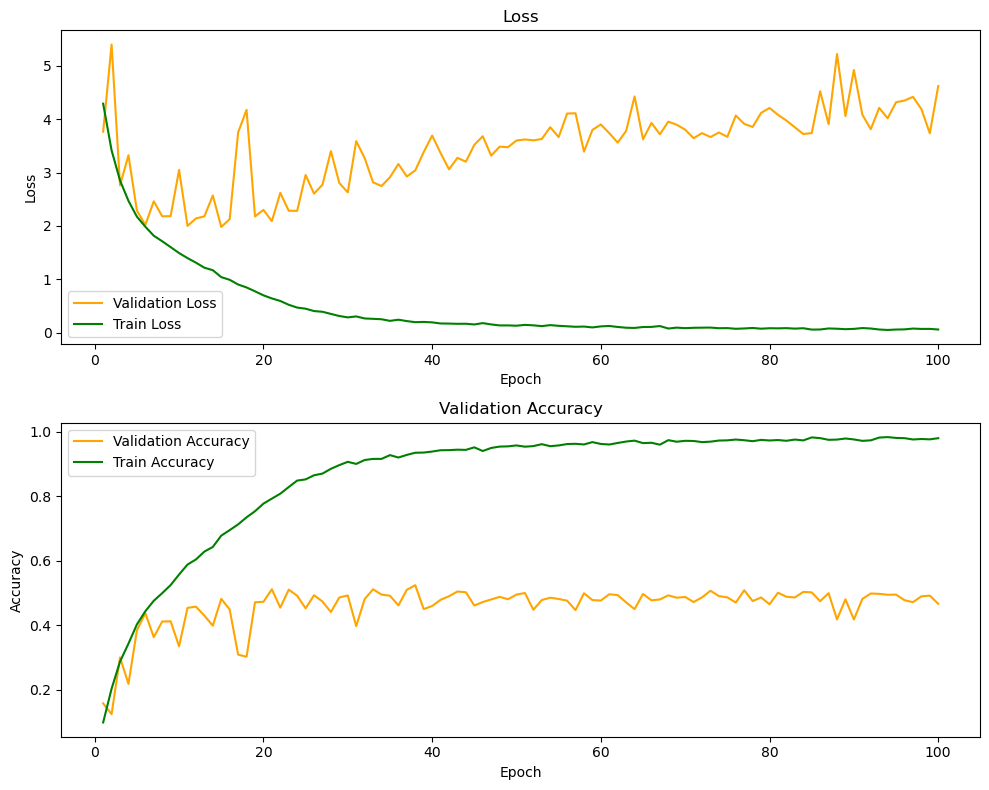

In [115]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
epochs = range(1, len(val_loss_array)+1)
# Plot validation loss
ax1.plot(epochs, val_loss_array, 'orange', label='Validation Loss')
ax1.plot(epochs, train_loss_array, 'green',  label='Train Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(epochs, val_acc_array, 'orange', label='Validation Accuracy')
ax2.plot(epochs, train_acc_array, 'green', label='Train Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### CNN model 2

In [135]:
class CNN_model2(nn.Module):
    def __init__(self):
        super(CNN_model2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(8192, 100)
        )

    def forward(self, x):
        x = self.features(x) 
        # print(x.shape)
        x = self.classifier(x)
        return x

# Create an instance of the modified ResNet50 model
model = CNN_model2()

# Display the model summary
print(model)


CNN_model2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(5, 5), s

In [136]:
model = CNN_model2()
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [137]:
model = CNN_model2()
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 50, save_weights = False, weights_path = "resnet18")

Epoch [1/50], Train Loss: 5.7136, Train Accuracy: 6.23%
Epoch [1/50], Val Loss: 5.6072, Val Accuracy: 4.50%
Epoch [2/50], Train Loss: 4.9874, Train Accuracy: 13.93%
Epoch [2/50], Val Loss: 3.9442, Val Accuracy: 16.85%
Epoch [3/50], Train Loss: 4.2379, Train Accuracy: 20.71%
Epoch [3/50], Val Loss: 3.9606, Val Accuracy: 16.96%
Epoch [4/50], Train Loss: 3.6863, Train Accuracy: 25.38%
Epoch [4/50], Val Loss: 3.1971, Val Accuracy: 30.23%
Epoch [5/50], Train Loss: 3.1605, Train Accuracy: 29.38%
Epoch [5/50], Val Loss: 3.9271, Val Accuracy: 20.23%
Epoch [6/50], Train Loss: 2.6864, Train Accuracy: 34.46%
Epoch [6/50], Val Loss: 2.9232, Val Accuracy: 30.04%
Epoch [7/50], Train Loss: 2.3627, Train Accuracy: 38.63%
Epoch [7/50], Val Loss: 2.7682, Val Accuracy: 31.62%
Epoch [8/50], Train Loss: 2.1070, Train Accuracy: 42.54%
Epoch [8/50], Val Loss: 2.5096, Val Accuracy: 36.12%
Epoch [9/50], Train Loss: 1.8897, Train Accuracy: 46.56%
Epoch [9/50], Val Loss: 2.2827, Val Accuracy: 39.65%
Epoch [10/50

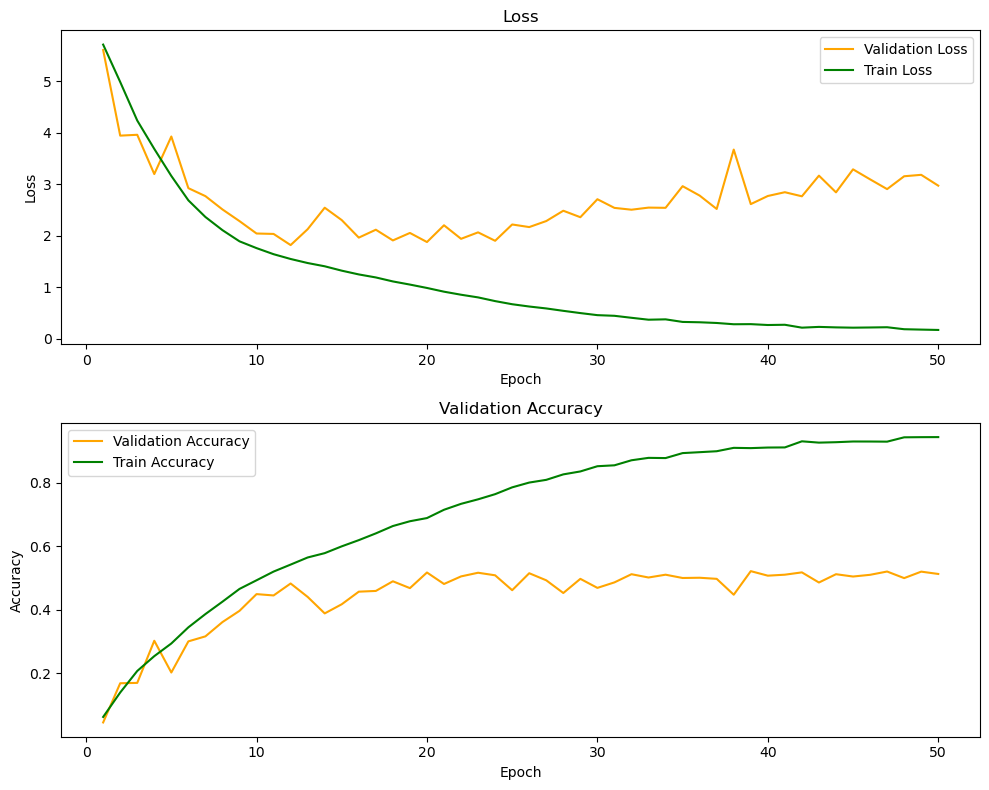

In [138]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
epochs = range(1, len(val_loss_array)+1)
# Plot validation loss
ax1.plot(epochs, val_loss_array, 'orange', label='Validation Loss')
ax1.plot(epochs, train_loss_array, 'green',  label='Train Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(epochs, val_acc_array, 'orange', label='Validation Accuracy')
ax2.plot(epochs, train_acc_array, 'green', label='Train Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### CNN model 3

In [143]:
class CNN_model3(nn.Module):
    def __init__(self):
        super(CNN_model3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(2048, 100)
        )

    def forward(self, x):
        x = self.features(x) 
        # print(x.shape)
        x = self.classifier(x)
        return x

# Create an instance of the modified ResNet50 model
model = CNN_model3()

# Display the model summary
print(model)


CNN_model3(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(5, 5), s

In [144]:
model = CNN_model3()
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [145]:
model = CNN_model3()
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 50, save_weights = False, weights_path = "resnet18")

Epoch [1/50], Train Loss: 4.6605, Train Accuracy: 5.08%
Epoch [1/50], Val Loss: 8.9658, Val Accuracy: 3.12%
Epoch [2/50], Train Loss: 4.1472, Train Accuracy: 9.44%
Epoch [2/50], Val Loss: 6.2206, Val Accuracy: 6.96%
Epoch [3/50], Train Loss: 3.6426, Train Accuracy: 14.12%
Epoch [3/50], Val Loss: 3.4537, Val Accuracy: 18.12%
Epoch [4/50], Train Loss: 3.2820, Train Accuracy: 18.60%
Epoch [4/50], Val Loss: 3.2319, Val Accuracy: 19.42%
Epoch [5/50], Train Loss: 2.9616, Train Accuracy: 22.56%
Epoch [5/50], Val Loss: 3.0590, Val Accuracy: 22.08%
Epoch [6/50], Train Loss: 2.7387, Train Accuracy: 26.11%
Epoch [6/50], Val Loss: 2.8411, Val Accuracy: 24.88%
Epoch [7/50], Train Loss: 2.5487, Train Accuracy: 30.15%
Epoch [7/50], Val Loss: 2.7121, Val Accuracy: 27.50%
Epoch [8/50], Train Loss: 2.3779, Train Accuracy: 33.55%
Epoch [8/50], Val Loss: 2.6142, Val Accuracy: 30.42%
Epoch [9/50], Train Loss: 2.2479, Train Accuracy: 36.18%
Epoch [9/50], Val Loss: 2.2359, Val Accuracy: 37.96%
Epoch [10/50],

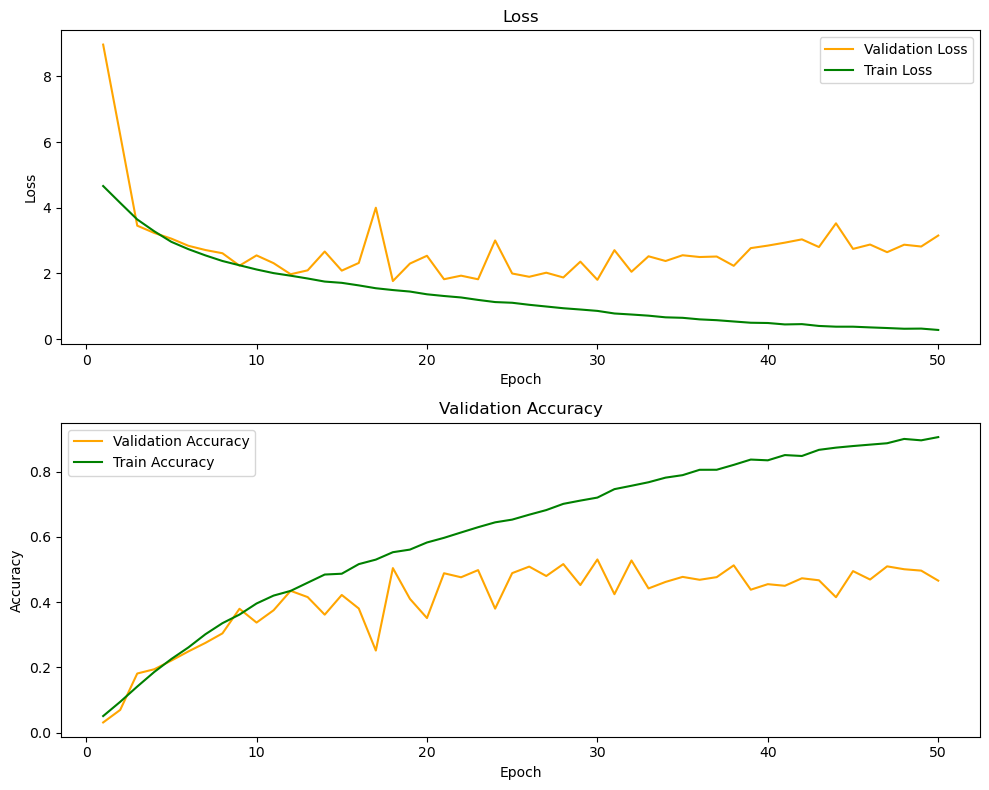

In [146]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
epochs = range(1, len(val_loss_array)+1)
# Plot validation loss
ax1.plot(epochs, val_loss_array, 'orange', label='Validation Loss')
ax1.plot(epochs, train_loss_array, 'green',  label='Train Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(epochs, val_acc_array, 'orange', label='Validation Accuracy')
ax2.plot(epochs, train_acc_array, 'green', label='Train Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### CNN model 4

In [248]:
class CNN_model4(nn.Module):
    def __init__(self):
        super(CNN_model4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.75),
            nn.Linear(4096, 100)
        )

    def forward(self, x):
        x = self.features(x) 
        # print(x.shape)
        x = self.classifier(x)
        return x

# Create an instance of the modified ResNet50 model
model = CNN_model4()

# Display the model summary
print(model)


CNN_model4(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(5, 5), s

In [249]:
model = CNN_model4()
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [252]:
model = CNN_model4()
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 2, save_weights = False, weights_path = "resnet18")

Epoch [1/2], Train Loss: 5.3686, Train Accuracy: 3.67%
Epoch [1/2], Val Loss: 4.6973, Val Accuracy: 5.73%
Epoch [2/2], Train Loss: 5.1416, Train Accuracy: 6.13%
Epoch [2/2], Val Loss: 4.1754, Val Accuracy: 8.00%


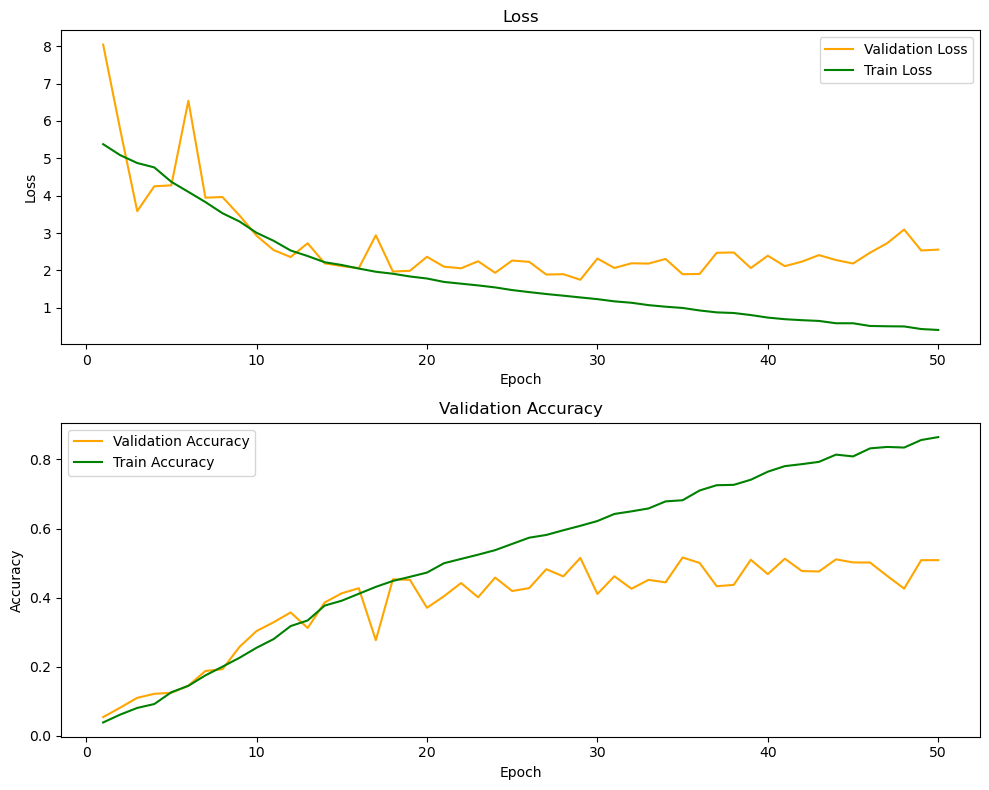

In [162]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
epochs = range(1, len(val_loss_array)+1)
# Plot validation loss
ax1.plot(epochs, val_loss_array, 'orange', label='Validation Loss')
ax1.plot(epochs, train_loss_array, 'green',  label='Train Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(epochs, val_acc_array, 'orange', label='Validation Accuracy')
ax2.plot(epochs, train_acc_array, 'green', label='Train Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## VGG model

In [39]:
models.vgg19()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
class VGG_model(nn.Module):
    def __init__(self):
        super(CNN_model1, self).__init__()
        # Add a custom convolutional layer
        vgg = models.vgg11_bn(pretrained=False)
        vgg.classifier[6] = nn.Linear(in_features=4096, out_features=100, bias=True)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.flatten = nn.Flatten()
        self.classifier = vgg.classifier

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = self.avgpool(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.classifier(x)
        # print(x.shape)
        
        return x

# Create an instance of the modified ResNet50 model
model = CNN_model1()

# Display the model summary
print(model)


/root/.conda/envs/calls2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.conda/envs/calls2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CNN_model1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPo

In [9]:
model = CNN_model1()
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [13]:
model = CNN_model1()
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 10, weights_path = "vgg11", last_epoch = 0)

Epoch [1/10], Train Loss: 5.4862, Train Accuracy: 1.18%
Epoch [1/10], Val Loss: 4.5118, Val Accuracy: 1.58%
Epoch [2/10], Train Loss: 4.5401, Train Accuracy: 1.62%
Epoch [2/10], Val Loss: 4.5232, Val Accuracy: 1.88%
Epoch [3/10], Train Loss: 4.5216, Train Accuracy: 1.50%
Epoch [3/10], Val Loss: 4.4504, Val Accuracy: 2.00%
Epoch [4/10], Train Loss: 4.5510, Train Accuracy: 1.81%
Epoch [4/10], Val Loss: 4.4594, Val Accuracy: 1.65%
Epoch [5/10], Train Loss: 4.5971, Train Accuracy: 1.31%
Epoch [5/10], Val Loss: 4.4626, Val Accuracy: 1.54%
Epoch [6/10], Train Loss: 4.4924, Train Accuracy: 1.76%
Epoch [6/10], Val Loss: 4.4072, Val Accuracy: 1.38%
Epoch [7/10], Train Loss: 4.4971, Train Accuracy: 1.71%
Epoch [7/10], Val Loss: 4.3620, Val Accuracy: 2.42%
Epoch [8/10], Train Loss: 4.4036, Train Accuracy: 1.71%
Epoch [8/10], Val Loss: 4.2661, Val Accuracy: 1.54%
Epoch [9/10], Train Loss: 4.3328, Train Accuracy: 1.96%
Epoch [9/10], Val Loss: 4.2538, Val Accuracy: 2.50%
Epoch [10/10], Train Loss: 4

## ResNet18

In [25]:
resnet = models.resnet18(pretrained=False)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
class ResNet18Modified(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet18Modified, self).__init__()
        resnet = models.resnet18(pretrained=False)
        # resnet.layer1[0].conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        # Add a custom convolutional layer
        self.custom_conv = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0)
        
        # Remove the fully connected layers at the end
        self.features = nn.Sequential(*list(resnet.children())[4:-2])
        
        # # Global average pooling
        self.avgpool = resnet.avgpool
        
        # Fully connected layer for predictions
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.custom_conv(x)
        # print(x.shape)
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = F.softmax(x, dim=1)
        return x

# Create an instance of the modified ResNet50 model
model = ResNet18Modified()

# Display the model summary
print(model)


ResNet18Modified(
  (custom_conv): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1))
  (features): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

/root/.conda/envs/calls2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.conda/envs/calls2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [60]:
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [64]:
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 10, weights_path = "resnet18")

Epoch [1/10], Train Loss: 3.4184, Train Accuracy: 14.10%
Epoch [1/10], Val Loss: 3.3110, Val Accuracy: 19.46%
Epoch [2/10], Train Loss: 2.5873, Train Accuracy: 28.76%
Epoch [2/10], Val Loss: 2.6875, Val Accuracy: 28.96%
Epoch [3/10], Train Loss: 2.1301, Train Accuracy: 39.32%
Epoch [3/10], Val Loss: 2.2322, Val Accuracy: 37.46%
Epoch [4/10], Train Loss: 1.8044, Train Accuracy: 46.75%
Epoch [4/10], Val Loss: 1.9586, Val Accuracy: 43.73%
Epoch [5/10], Train Loss: 1.5709, Train Accuracy: 53.47%
Epoch [5/10], Val Loss: 2.2797, Val Accuracy: 38.31%
Epoch [6/10], Train Loss: 1.3746, Train Accuracy: 58.66%
Epoch [6/10], Val Loss: 1.7745, Val Accuracy: 49.58%
Epoch [7/10], Train Loss: 1.1892, Train Accuracy: 63.15%
Epoch [7/10], Val Loss: 1.5955, Val Accuracy: 54.15%
Epoch [8/10], Train Loss: 1.0680, Train Accuracy: 66.92%
Epoch [8/10], Val Loss: 1.8568, Val Accuracy: 48.81%
Epoch [9/10], Train Loss: 0.9200, Train Accuracy: 71.04%
Epoch [9/10], Val Loss: 1.3516, Val Accuracy: 61.00%
Epoch [10/

In [67]:
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 10, weights_path = "resnet18", last_epoch = 9)

Epoch [10/10], Train Loss: 0.6983, Train Accuracy: 77.68%
Epoch [10/10], Val Loss: 1.6260, Val Accuracy: 56.50%
Epoch [11/10], Train Loss: 0.5379, Train Accuracy: 82.83%
Epoch [11/10], Val Loss: 1.6930, Val Accuracy: 55.96%
Epoch [12/10], Train Loss: 0.4487, Train Accuracy: 85.85%
Epoch [12/10], Val Loss: 1.6788, Val Accuracy: 56.88%
Epoch [13/10], Train Loss: 0.3583, Train Accuracy: 88.41%
Epoch [13/10], Val Loss: 1.5191, Val Accuracy: 60.77%
Epoch [14/10], Train Loss: 0.2849, Train Accuracy: 91.09%
Epoch [14/10], Val Loss: 1.7610, Val Accuracy: 57.27%
Epoch [15/10], Train Loss: 0.2125, Train Accuracy: 93.57%
Epoch [15/10], Val Loss: 1.7129, Val Accuracy: 59.27%
Epoch [16/10], Train Loss: 0.1580, Train Accuracy: 95.37%
Epoch [16/10], Val Loss: 1.8437, Val Accuracy: 59.12%
Epoch [17/10], Train Loss: 0.1728, Train Accuracy: 94.71%
Epoch [17/10], Val Loss: 1.9993, Val Accuracy: 58.08%
Epoch [18/10], Train Loss: 0.1380, Train Accuracy: 95.96%
Epoch [18/10], Val Loss: 1.8509, Val Accuracy:

## ResNet50 torch

In [35]:
class ResNet50Modified(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet50Modified, self).__init__()
        resnet = resnet50(pretrained=False)
        
        # Add a custom convolutional layer
        # self.custom_conv = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0)
        
        # Remove the fully connected layers at the end
        self.features = nn.Sequential(*list(resnet.children())[4:-2])
        
        # # Global average pooling
        self.avgpool = resnet.avgpool
        
        # Fully connected layer for predictions
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        # x = x.permute(0, 3, 2, 1)
        print(x.shape)
        # x = self.custom_conv(x)
        # print(x.shape)
        x = self.features(x)
        print(x.shape)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = F.softmax(x, dim=1)
        return x

# Create an instance of the modified ResNet50 model
model = ResNet50Modified()

# Display the model summary
# print(model)


In [36]:
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 64, 64, 3])
torch.Size([1, 64, 64, 3])
torch.Size([1, 2048, 8, 1])
torch.Size([1, 100])


In [21]:
model = model.to('cuda')
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 10)

Epoch [1/10], Train Loss: 1.3550, Train Accuracy: 59.19%
Epoch [1/10], Val Loss: 2.2622, Val Accuracy: 42.58%
Epoch [2/10], Train Loss: 1.1580, Train Accuracy: 64.32%
Epoch [2/10], Val Loss: 2.2509, Val Accuracy: 43.81%
Epoch [3/10], Train Loss: 0.9914, Train Accuracy: 69.10%
Epoch [3/10], Val Loss: 2.2541, Val Accuracy: 44.00%
Epoch [4/10], Train Loss: 0.8609, Train Accuracy: 72.48%
Epoch [4/10], Val Loss: 2.3908, Val Accuracy: 43.73%
Epoch [5/10], Train Loss: 0.7269, Train Accuracy: 76.96%
Epoch [5/10], Val Loss: 2.5445, Val Accuracy: 42.00%
Epoch [6/10], Train Loss: 0.6176, Train Accuracy: 80.19%
Epoch [6/10], Val Loss: 2.6942, Val Accuracy: 42.88%
Epoch [7/10], Train Loss: 0.5162, Train Accuracy: 83.46%
Epoch [7/10], Val Loss: 2.6490, Val Accuracy: 43.96%
Epoch [8/10], Train Loss: 0.4184, Train Accuracy: 86.82%
Epoch [8/10], Val Loss: 2.9267, Val Accuracy: 44.65%
Epoch [9/10], Train Loss: 0.3633, Train Accuracy: 88.36%
Epoch [9/10], Val Loss: 3.1622, Val Accuracy: 43.73%
Epoch [10/

In [45]:
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 15)

Epoch [1/15], Train Loss: 1.8013, Train Accuracy: 47.91%
Epoch [1/15], Val Loss: 1.9205, Val Accuracy: 46.35%
Epoch [2/15], Train Loss: 1.5424, Train Accuracy: 54.00%
Epoch [2/15], Val Loss: 1.7412, Val Accuracy: 49.12%
Epoch [3/15], Train Loss: 1.3924, Train Accuracy: 58.31%
Epoch [3/15], Val Loss: 2.8729, Val Accuracy: 31.38%
Epoch [4/15], Train Loss: 1.2294, Train Accuracy: 62.82%
Epoch [4/15], Val Loss: 1.7354, Val Accuracy: 52.54%
Epoch [5/15], Train Loss: 1.1086, Train Accuracy: 65.93%
Epoch [5/15], Val Loss: 1.6384, Val Accuracy: 55.65%
Epoch [6/15], Train Loss: 0.9855, Train Accuracy: 69.10%
Epoch [6/15], Val Loss: 1.4648, Val Accuracy: 57.15%
Epoch [7/15], Train Loss: 0.8784, Train Accuracy: 71.86%
Epoch [7/15], Val Loss: 2.0676, Val Accuracy: 49.23%
Epoch [8/15], Train Loss: 0.7866, Train Accuracy: 74.85%
Epoch [8/15], Val Loss: 1.4229, Val Accuracy: 61.23%
Epoch [9/15], Train Loss: 0.7124, Train Accuracy: 76.86%
Epoch [9/15], Val Loss: 1.6768, Val Accuracy: 58.23%
Epoch [10/

## Test on validation data

In [433]:
# Specify the paths
images_folder_path = "val_images"
labels_path = "val.csv"

# Load images and labels into tensors
val_images, val_labels = load_images_and_labels(images_folder_path, labels_path)

# Print the shapes of the resulting tensors
print("Images Tensor Shape:", val_images.shape)
print("Labels Tensor Shape:", val_labels.shape)

X_val = torch.tensor(val_images, dtype=torch.float32).to('cuda')
X_val = X_val.permute((0, 3, 2, 1))

y_val = torch.tensor(val_labels, dtype=torch.int64).to('cuda')


Reading images: 100%|██████████| 2000/2000 [00:02<00:00, 882.28it/s]


Images Tensor Shape: torch.Size([2000, 64, 64, 3])
Labels Tensor Shape: torch.Size([2000])


/tmp/ipykernel_22081/250395293.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(val_images, dtype=torch.float32).to('cuda')
/tmp/ipykernel_22081/250395293.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(val_labels, dtype=torch.int64).to('cuda')


In [440]:
model2 = ResNet(BasicBlock, [2, 2, 2, 2]).to("cuda")
model2.load_state_dict(torch.load('weights/resnet_var1_epoch30.pth'))


<All keys matched successfully>

In [469]:
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [435]:
dataset = TensorDataset(X_val, y_val)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

model2.eval()  # Set the model to evaluation mode
model2.to("cuda")

all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation during validation
    correct_predictions = 0
    for inputs, labels in data_loader:
        inputs = inputs.to('cuda') # Move input data to GPU
        labels = labels.type(torch.LongTensor)
        labels = labels.to('cuda')
        # print(inputs.shape)

        outputs = model2(inputs)
        # print(outputs.shape)
        loss = nn.CrossEntropyLoss(outputs, labels)

        predictions = torch.argmax(outputs, dim=1).float()
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        # print(predictions.cpu().numpy(), labels.cpu().numpy())
        # break
        # correct_predictions += (predictions == labels).sum().item()


/root/.conda/envs/calls2/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/root/.conda/envs/calls2/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [439]:
f1 = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' takes class imbalance into account

print(f'Test F1 Score: {f1:.4f}')

Test F1 Score: 0.7035


## Predict test data

In [451]:
def predict_from_test_data(model, images_path):
    images_paths = os.listdir(images_path)
    images = []
    filenames = []
    for filename in tqdm(images_paths, desc = "Reading images"):
        if filename.endswith(".png"):
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img) / 255
            images.append(img_array)
            filenames.append(filename)
    images = np.array(images)
    images_tensor = torch.Tensor(images)
    # images_tensor = torch.tensor(images, dtype=torch.float32).to('cuda')
    images_tensor = images_tensor.permute((0, 3, 2, 1))
    dataset = TensorDataset(images_tensor)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    model.eval()  # Set the model to evaluation mode
    model.to("cuda")
    
    all_predictions = []
    with torch.no_grad():  # Disable gradient computation during prediction
        for inputs in data_loader:            
            inputs = inputs[0].to('cuda')  # Move input data to GPU
            outputs = model(inputs)
    
            predictions = torch.argmax(outputs, dim=1).float()
            all_predictions.append(predictions.cpu().numpy())

    return filenames, all_predictions

In [452]:
images_names_val, predicted_labels_val =  predict_from_test_data(model2, "val_images")

Reading images: 100%|██████████| 2000/2000 [00:00<00:00, 2023.36it/s]


In [454]:
images_names_test, predicted_labels_test =  predict_from_test_data(model2, "test_images")

Reading images: 100%|██████████| 5000/5000 [00:27<00:00, 183.01it/s]


In [453]:
f1 = f1_score(y_val, predicted_labels_val, average='weighted')  # 'weighted' takes class imbalance into account

print(f'Test F1 Score: {f1:.4f}')

Test F1 Score: 0.7035


In [459]:
predicted_labels_test_array = [int(x[0]) for x in predicted_labels_test]

In [460]:
predicted_labels_test_array

[96,
 4,
 91,
 10,
 59,
 44,
 19,
 96,
 31,
 56,
 40,
 84,
 25,
 14,
 59,
 22,
 86,
 11,
 76,
 56,
 96,
 57,
 88,
 59,
 31,
 72,
 35,
 59,
 30,
 64,
 9,
 18,
 87,
 31,
 57,
 14,
 84,
 52,
 32,
 32,
 72,
 51,
 55,
 21,
 21,
 48,
 30,
 59,
 42,
 20,
 45,
 88,
 58,
 91,
 72,
 36,
 71,
 54,
 95,
 82,
 95,
 5,
 89,
 63,
 41,
 40,
 13,
 31,
 99,
 8,
 69,
 81,
 45,
 40,
 28,
 14,
 15,
 87,
 42,
 70,
 25,
 35,
 16,
 78,
 8,
 48,
 1,
 96,
 44,
 96,
 9,
 62,
 30,
 90,
 36,
 95,
 73,
 85,
 45,
 27,
 90,
 17,
 65,
 85,
 27,
 74,
 88,
 9,
 32,
 78,
 10,
 61,
 30,
 82,
 94,
 40,
 36,
 70,
 93,
 65,
 61,
 35,
 88,
 81,
 11,
 86,
 16,
 20,
 26,
 54,
 80,
 10,
 43,
 61,
 57,
 65,
 48,
 68,
 63,
 12,
 69,
 5,
 10,
 65,
 99,
 7,
 6,
 19,
 26,
 49,
 25,
 95,
 0,
 42,
 49,
 77,
 19,
 53,
 16,
 90,
 43,
 30,
 72,
 75,
 6,
 2,
 27,
 65,
 98,
 82,
 94,
 30,
 99,
 20,
 91,
 68,
 78,
 66,
 16,
 59,
 84,
 51,
 48,
 1,
 8,
 60,
 51,
 77,
 95,
 98,
 97,
 36,
 65,
 60,
 16,
 14,
 71,
 11,
 54,
 48,
 77,
 39,
 72,
 

In [463]:
import csv 

data = list(zip(images_names_val_test, predicted_labels_test_array))

# Specify the CSV file path
csv_file_path = "predictions2.csv"

# Write data to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(['Image', 'Class'])
    
    # Write the data
    writer.writerows(data)

print(f"CSV file '{csv_file_path}' has been successfully created.")

CSV file 'predictions2.csv' has been successfully created.


In [461]:
from collections import Counter

count = Counter(predicted_labels_test_array)
deviations = [abs(value - 20) for value in count.values()]


In [462]:
sum(deviations)


3066

In [464]:
count

Counter({96: 92,
         4: 49,
         91: 52,
         10: 130,
         59: 119,
         44: 57,
         19: 42,
         31: 47,
         56: 38,
         40: 66,
         84: 72,
         25: 45,
         14: 63,
         22: 51,
         86: 49,
         11: 41,
         76: 54,
         57: 84,
         88: 62,
         72: 64,
         35: 61,
         30: 72,
         64: 29,
         9: 49,
         18: 43,
         87: 19,
         52: 23,
         32: 47,
         51: 49,
         55: 39,
         21: 51,
         48: 54,
         42: 37,
         20: 70,
         45: 27,
         58: 45,
         36: 45,
         71: 41,
         54: 68,
         95: 65,
         82: 55,
         5: 40,
         89: 48,
         63: 55,
         41: 71,
         13: 44,
         99: 58,
         8: 42,
         69: 47,
         81: 36,
         28: 57,
         15: 49,
         70: 40,
         16: 47,
         78: 51,
         1: 41,
         62: 63,
         90: 63,
         73: 35,
